_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-04-30, 9am

Student names: Guillem Boada, Ulzii-Utas

# Exercise sheet 2

If needed, download the data files ```nda_ex_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging. But be careful not to make it too small, since the algorithm may fail to detect small clusters in this case. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
import scipy as sp
from scipy.io import loadmat
import copy
from scipy import linalg
import statistics
import math
from numpy.linalg import inv
from numpy import matmul, transpose, dot
from numba import jit, cuda, vectorize
from scipy.stats import multivariate_normal
import time

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [41]:
# replace by path to your solutions
b = np.load('../data/nda_ex_1_features.npy')
s = np.load('../data/nda_ex_1_spiketimes.npy')
w = np.load('../data/nda_ex_1_waveforms.npy')


## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [3]:
def sampleData(N, m, S, p):
#    Generate N samples from a Mixture of Gaussian distribution with
#    means m, covariances S and priors p. The function returns the sampled
#    datapoints x as well as an indicator for the cluster the point 
#    originated from. The number of samples is rounded to the nearest integer.
#
#    m     #components x #dim
#    S     #dim x #dim x #components
#    p     #components
#
#    x     N x #dim
#    ind   N
    
#   initialize the x and ind
    x = np.zeros([N, 2]);
    ind = np.zeros(N);
    
    dist_uni = np.random.uniform(0, 1, N);
        
    for i in range(N):
        
        if dist_uni[i] < p[0]:
            
            ind[i] = (0);            
            x[i, :] = np.random.multivariate_normal(m[0, :], S[:, :, 0], 1);
            
        elif dist_uni[i] < p[0] + p[1]:
            
            ind[i] = (1);
            x[i, :] = np.random.multivariate_normal(m[1, :], S[:, :, 1], 1);
            
        else:            
            
            ind[i] = (2);
            x[i, :] = np.random.multivariate_normal(m[2, :], S[:, :, 2], 1);
    
    return (x,ind)    


Specify parameters of Gaussians and run function

Plot the toy dataset

In [4]:
N = 1000
m = np.array([[0, 0], [5, 1], [0, 4]])
S1 = np.array([[1, 0], [0, 1]])
S2 = np.array([[2, 1], [1, 2]])
S3 = np.array([[1, -.5], [-.5, 1]])
S = np.concatenate((S1[:,:,np.newaxis],
                    S2[:,:,np.newaxis],
                    S3[:,:,np.newaxis]), axis=2)
p = np.array([.3, .5, .2])

x, ind = sampleData(N, m, S, p)


(-4, 10)

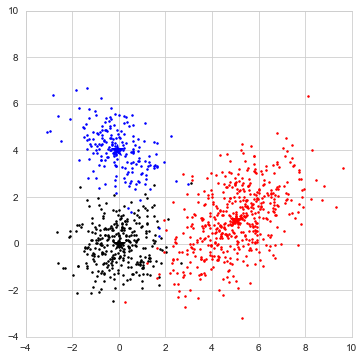

In [5]:
plt.figure(figsize=(6, 6))

ax = plt.subplot(1,1,1, aspect='equal')
plt.plot(x[ind==0,0],x[ind==0,1],'.k', markersize=3) 
plt.plot(x[ind==1,0],x[ind==1,1],'.r', markersize=3) 
plt.plot(x[ind==2,0],x[ind==2,1],'.b', markersize=3)

plt.plot(np.mean(x[ind==0,0]),np.mean(x[ind==0,1]),'*k', markersize=12) 
plt.plot(np.mean(x[ind==1,0]),np.mean(x[ind==1,1]),'*r', markersize=12) 
plt.plot(np.mean(x[ind==2,0]),np.mean(x[ind==2,1]),'*b', markersize=12)

plt.xlim((-4,10))
plt.ylim((-4,10))


## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [6]:
@jit(nopython=True)
def mog(x, k, m, S, p, y):
# Fit Mixture of Gaussian model
#   ind, m, S, p = mog(x,k) fits a Mixture of Gaussian model to the data in
#   x using k components. The output ind contains the MAP assignments of the
#   datapoints in x to the found clusters. The outputs m, S, p contain
#   the model parameters.
#
#   x:     N by D
#
#   ind:   N by 1
#   m:     k by D
#   S:     D by D by k
#   p:     k by 1

    # fill in your code here
    N = len(x[:, 0]);
    feature = len(x[0]);
    
    iteration = 100;
    iter_count = 0;
    
    threshold = 1e-30;
    log_likelihood_old = 0;
    log_likelihood_new = 1;
    
    matmul_arr = np.zeros(features);
    feature_arr_ = np.zeros(features);
    feature_2d_arr_ = np.zeros((features, features));
    ind = np.zeros(N);
    arr = np.zeros(k);
    
    while iter_count < iteration and np.abs(log_likelihood_old - log_likelihood_new) > threshold:

#         Expectation Step
        
        for j in range(N):           
            sum_tmp = 0;
            for i in range(k): 
#                 x - mean
                minus = x[j] - m[i];
                
#                 inverse of covariance
                S_inverse = inv(S[:, :, i]);
                    
#                 matrix multiplication of inverse of covariance and x - mean
                for l in range(feature):
                    tmp_val = 0;
                    for o in range(feature):
                        tmp_val += minus[o]*S_inverse[l][o];
                    matmul_arr[l] = tmp_val;
                    
#                 matrix multiplication of previos step with transpose of x - mean
                matmul_tmp = 0;
                for l in range(feature):
                    matmul_tmp += matmul_arr[l] * minus[l];  
                    
                exp_tmp = np.exp(-0.5 * matmul_tmp);
                posterior = (p[i] / (2 * math.pi * np.sqrt(np.linalg.det(S[:, :, i])))) * exp_tmp;
                sum_tmp += posterior;
                y[j][i] = posterior;
                
            for i in range(k):
                y[j][i] = y[j][i] /sum_tmp; 
                
        N_k = np.zeros(k);
        
#         Maximization step 
#         finding Nk
        for i in range(k):
            for j in range(N):
                N_k[i] += y[j][i];
                
#         calculating p
        for i in range(k):
            p[i] = N_k[i] / N;                
                
        for i in range(k):   
            for l in range(feature):
                feature_arr_[l] = 0;
            
#             posterior at n * data at n                
            for j in range(N):
                for l in range(feature):
                    feature_arr_[l] += y[j][i] * x[j][l];                   
                    
#             Normalize to get mean for each feature
            for l in range(feature):            
                m[i][l] = feature_arr_[l]/N_k[i];
                    
            for l in range(feature):
                for o in range(feature):
                    feature_2d_arr_[l][o] = 0;
                                
#             posterior at n * (x - mean) * transpose(x - mean)
                                        
            for j in range(N):                      
                tmp_arr = x[j] - m[i];                  
                for l in range(feature):
                    for o in range(feature):
                        feature_2d_arr_[l][o] += y[j][i] * (tmp_arr[l] * tmp_arr[o]);
                        
#             Normalize to get covariance
            for l in range(feature):
                for o in range(feature):
                    S[l, o, i] = feature_2d_arr_[l][o]/N_k[i];
            
        iter_count += 1; 
        
        log_likelihood_old = log_likelihood_new;        
        log_likelihood_new = 0;
        
        for j in range(N): 
            
            log_sum = 0;
            
            for i in range(k):
#                 x - mean
                minus = x[j] - m[i];
                                    
#                 inverse of covariance
                S_inverse = inv(S[:, :, i]);
                
#                 matrix multiplication of inverse of covariance and x - mean
                for l in range(feature):
                    tmp_val = 0;
                    for o in range(feature):
                        tmp_val += minus[o]*S_inverse[l][o];
                        
                    matmul_arr[l] = tmp_val;
                    
                matmul_tmp = 0;
                
#                 matrix multiplication of previos step with transpose of x - mean
                for l in range(feature):
                    matmul_tmp += matmul_arr[l] * minus[l];
                
                exp_tmp = np.exp(-0.5 * matmul_tmp);
                posterior = (p[i] / (2 * math.pi * np.sqrt(np.linalg.det(S[:, :, i])))) * exp_tmp;
                
                log_sum += math.log(posterior);
                
#                 sum everyting to get LL
            log_likelihood_new += log_sum;
    
    for j in range(N): 
        for i in range(k):
            arr[i] = y[j][i];
        ind[j] = np.argmax(arr);
                
    return (ind, m, S, p)

In [29]:
# @jit(nopython=True)
def mog_opti(x, k, m, S, p, y):
# Fit Mixture of Gaussian model
#   ind, m, S, p = mog(x,k) fits a Mixture of Gaussian model to the data in
#   x using k components. The output ind contains the MAP assignments of the
#   datapoints in x to the found clusters. The outputs m, S, p contain
#   the model parameters.
#
#   x:     N by D
#
#   ind:   N by 1
#   m:     k by D
#   S:     D by D by k
#   p:     k by 1

    # fill in your code here
    N = len(x[:, 0]);
    feature = len(x[0]);
    
    iteration = 100;
    iter_count = 0;
    
    threshold = 1e-30;
    log_likelihood_old = 0;
    log_likelihood_new = 1;
    
    
#      and np.abs(log_likelihood_old - log_likelihood_new) > threshold
    while iter_count < iteration and np.abs(log_likelihood_old - log_likelihood_new) > threshold:

#         Expectation Step   
        y_sum = np.zeros(N);
#         x_transpose = x.transpose();
        
        for i in range(k): 
#           x - mean
            tmp_arr_e_subtract = np.subtract(x.transpose(), m[i].reshape(len(m[i]), 1));
            tmp_arr_e_dot = tmp_arr_e_subtract.copy();
            
#           inverse of covariance
            S_inverse = inv(S[:, :, i]);
            
#           (x - mean) * covariance
            for l in range(feature):
                tmp_arr_e_dot[l] = np.sum(np.multiply(tmp_arr_e_subtract,S_inverse[:,l:l+1]), axis=0);
                
#           (x - mean) * covariance * (x-mean)
            tmp_arr_e = np.zeros(N);
            tmp_arr_e = np.sum(np.multiply(tmp_arr_e_subtract,tmp_arr_e_dot), axis=0);  
#           power to e        
            tmp_arr_e = np.exp(np.multiply(-0.5, tmp_arr_e));
            tmp_arr_e = np.multiply(p[i] / (2 * math.pi * np.sqrt(np.linalg.det(S[:, :, i]))), tmp_arr_e);
                        
            y_sum = tmp_arr_e + y_sum;

            y[:,i] = tmp_arr_e.copy();
            
        y = np.divide(y,y_sum.reshape(len(y_sum), 1));
        
#         calculating log likelihood
        if iter_count != 0:
            log_likelihood_old = log_likelihood_new;        
            log_likelihood_new = 0;        
            y_sum = np.log(y_sum);
            log_likelihood_new = np.sum(y_sum);
            if np.abs(log_likelihood_old - log_likelihood_new) < threshold:
                break;    
                
        N_k = np.zeros(k);
        
#         Maximization step 
#         finding Nk
        t_y = y.transpose();
        for i in range(k):
            N_k[i] = np.sum(t_y[i]);
                
#         calculating p
        for i in range(k):
            p[i] = N_k[i] / N;      
#         for each k find mean and covariance
        
        for i in range(k):                           
            for l in range(feature):
                m[i][l] = np.dot(t_y[i], x.transpose()[l])/N_k[i];   
                
            tmp_arr_multiply = np.subtract(x.transpose(), m[i].reshape(len(m[i]), 1));                  
            
            
            matrix_multiply_nn = np.zeros((features, len(x[:,0])));
            matrix_multiply_nn[0:feature,:] = np.multiply(tmp_arr_multiply,tmp_arr_multiply);
            
            for l in range(feature):
                for j in range(l + 1, feature):     
                    S[l, j, i] = np.dot(np.multiply(tmp_arr_multiply[l],tmp_arr_multiply[j]), t_y[i])/N_k[i];                              
                    S[j, l, i] = S[l, j, i];
                    
            for l in range(feature):
                S[l, l, i] = np.dot(matrix_multiply_nn[l], t_y[i])/N_k[i];
            
            
        iter_count += 1; 
    
    t_y = y.transpose();            
    print(p);
    
    return (t_y, m, S, p)


Run Mixture of Gaussian on toy data

In [8]:
start = time.time()

k = 3;
features = len(x[0]);
m = np.zeros((features,k));
S = np.zeros((features,features,k));
p = np.zeros(k);

kmeans = KMeans(n_clusters=k).fit(x);
m = kmeans.cluster_centers_;
labels = kmeans.labels_;

for i in range(k):                
    S[:, :, i] = np.cov(x, rowvar = False);
    p[i] = sum(item == i for item in labels) / N;
    
y = np.zeros([N, k], dtype=np.float64);

t_y, m, S, p = mog_opti(x, k, m, S, p, y);
ind2 = np.argmax(t_y, axis = 0);
# ind2, m, S, p = mog(x, k, m, S, p, y);

end = time.time()
print(end - start)

0.0777897834777832


Plot toy data with cluster assignments and compare to original labels

Text(0.5, 1.0, 'MoG labels')

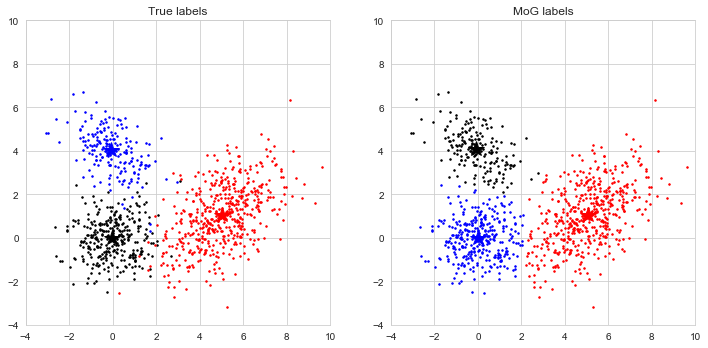

In [9]:
plt.figure(figsize=(12, 6))

ax = plt.subplot(1,2,1, aspect='equal')
plt.plot(x[ind==0,0],x[ind==0,1],'.k', markersize=3) 
plt.plot(x[ind==1,0],x[ind==1,1],'.r', markersize=3) 
plt.plot(x[ind==2,0],x[ind==2,1],'.b', markersize=3)
plt.plot(np.mean(x[ind==0,0]),np.mean(x[ind==0,1]),'*k', markersize=16) 
plt.plot(np.mean(x[ind==1,0]),np.mean(x[ind==1,1]),'*r', markersize=16) 
plt.plot(np.mean(x[ind==2,0]),np.mean(x[ind==2,1]),'*b', markersize=16)

plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('True labels')

ax = plt.subplot(1,2,2, aspect='equal')
plt.plot(x[ind2==0,0],x[ind2==0,1],'.k', markersize=3) 
plt.plot(x[ind2==1,0],x[ind2==1,1],'.r', markersize=3) 
plt.plot(x[ind2==2,0],x[ind2==2,1],'.b', markersize=3)
plt.plot(np.mean(x[ind2==0,0]),np.mean(x[ind2==0,1]),'*k', markersize=16) 
plt.plot(np.mean(x[ind2==1,0]),np.mean(x[ind2==1,1]),'*r', markersize=16) 
plt.plot(np.mean(x[ind2==2,0]),np.mean(x[ind2==2,1]),'*b', markersize=16)


plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('MoG labels')



## Task 3: Model complexity
A priori we do not how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 2 pts + 1 extra pt*



In [10]:
def mog_bic(x, m, S, p):
# Compute the BIC for a fitted Mixture of Gaussian model
#   bic, LL = mog_bic(x,k) computes the the Bayesian Information 
#   Criterion value and the log-likelihood of the fitted model.
#
#   x:     N by D
#   m:     k by D
#   S:     D by D by k

#   bic:   1 by 1
#   LL:    1 by 1

# fill in your code here
    K = len(S[0,0,:]);
    D = len(S[:,0,0]);
    
#     For each Gaussian you have:
#     1. A Symmetric full DxD covariance matrix giving (D*D - D)/2 + D parameters ((D*D - D)/2 
#     is the number of off-diagonal elements and D is the number of diagonal elements)
#     2. A D dimensional mean vector giving D parameters
#     3. A mixing weight giving another parameter

#     This results in Df = (D*D - D)/2 + 2D + 1 for each gaussian.
#     Given you have K components, you have (K*Df)-1 parameters. Because the mixing weights must 
#     sum to 1, you only need to find K-1 of them. The Kth weight can be calculated by subtracting 
#     the sum of the (K-1) weights from 1.

#     found the formula from the following stackexchange post
#     https://stats.stackexchange.com/questions/229293/the-number-of-parameters-in-gaussian-mixture-model

    P = ((D*D - D)/2 +2*D + 1)*K - 1;
    p_x = 0;
    
    for i in range(K):        
        p_x += p[i] * multivariate_normal(m[i], S[:, :, i]).pdf(x);
        
    LL = np.sum(np.log(p_x));
       
    
    bic = -2 * LL + P * math.log(len(x[:,0]));
    
    return (bic, LL)
    

Fit and compute the BIC for mixture models with different numbers of clusters (e.g., between 2 and 6).

In [11]:
K = [2, 3, 4, 5, 6]
BIC = np.zeros((3,len(K)))
LL = np.zeros((3,len(K)))

# run mog and BIC multiple times here
start = time.time()
for i in range(len(K)):
    for l in range(3):
        
        k = K[i];
        features = len(x[0]);
        m = np.zeros((features,k));
        S = np.zeros((features,features,k));
        p = np.zeros(k);

        kmeans = KMeans(n_clusters=k).fit(x);
        m = kmeans.cluster_centers_;
        labels = kmeans.labels_;

        for o in range(k):                
            S[:, :, o] = np.cov(x, rowvar = False);
            p[o] = sum(item == o for item in labels) / N;

        y = np.zeros([N, k], dtype=np.float64);

        ind_, m, S, p = mog_opti(x, k, m, S, p, y);
#         ind_, m, S, p = mog(x, k, m, S, p, y);
        BIC[l][i], LL[l][i] = mog_bic(x, m, S, p);
end = time.time()
print(end - start)

1.898918867111206


(1, 7)

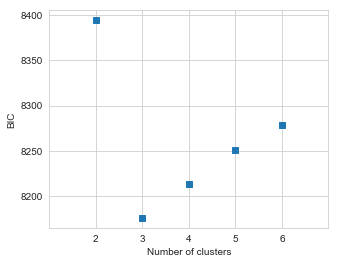

In [12]:
plt.figure(figsize=(5, 4))

plt.plot(K,np.min(BIC,axis=0),'s')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.xticks(K)
plt.xlim((1,7))

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [13]:
K = np.arange(2,20);
BIC = np.zeros(len(K));
LL = np.zeros(len(K));
N = len(b[:,0]);

start = time.time();
for i in range(len(K)):
    
    k = K[i];
    features = len(b[0]);
    m = np.zeros((features,k));
    S = np.zeros((features,features,k));
    p = np.zeros(k);

    kmeans = KMeans(n_clusters=k).fit(b);
    m = kmeans.cluster_centers_;
    labels = kmeans.labels_;

    for o in range(k):                
        S[:, :, o] = np.cov(b, rowvar = False);
        p[o] = sum(item == o for item in labels) / N;

    y = np.zeros([N, k], dtype=np.float64);

    ind_, m, S, p = mog_opti(b, k, m, S, p, y);
    BIC[i], LL[i] = mog_bic(b, m, S, p);

end = time.time();
print(end - start);
  

757.3884291648865


Plot BIC

(2, 20)

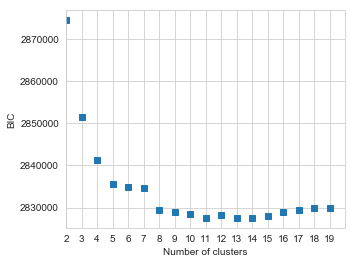

In [14]:
plt.figure(figsize=(5, 4));
plt.plot(K,BIC,'s');
plt.xlabel('Number of clusters');
plt.ylabel('BIC');
plt.xticks(K);
plt.xlim((2,20));

Refit model with lowest BIC and plot data points

In [33]:
start = time.time();
N = len(b[:,0]);
k = K[np.argmin(BIC)];
features = len(b[0]);
m = np.zeros((features,k));
S = np.zeros((features,features,k));
p = np.zeros(k);

kmeans = KMeans(n_clusters=k).fit(b);
m = kmeans.cluster_centers_;
labels = kmeans.labels_;

for o in range(k):                
    S[:, :, o] = np.cov(b, rowvar = False);
    p[o] = sum(item == o for item in labels) / N;

y = np.zeros([N, k], dtype=np.float64);

t_y, m, S, p = mog_opti(b, k, m, S, p, y);
a = np.argmax(t_y, axis = 0);

end = time.time();
print(end - start);

[0.11659573 0.05893676 0.10825126 0.0449808  0.09450071 0.04274169
 0.06901939 0.05115658 0.10466478 0.01981676 0.02393254 0.07978253
 0.18562049]
51.381635427474976


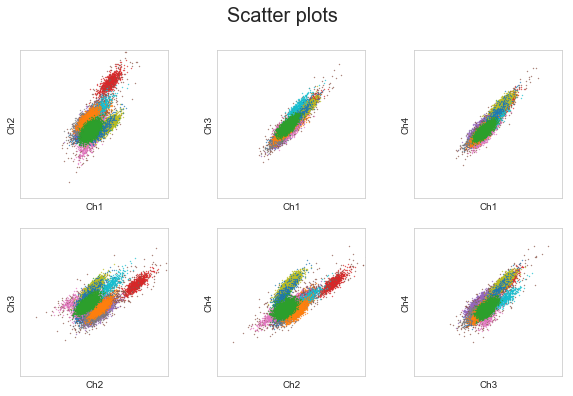

In [34]:
plt.figure(figsize=(10, 6));
plt.suptitle('Scatter plots',fontsize=20);

idx = [0, 3, 6, 9];
iter_count = 1;
labels = ['Ch1','Ch2','Ch3','Ch4'];
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,iter_count, aspect='equal');
        for l in range(k):
            plt.plot(b[a==l,idx[i]],b[a==l,idx[j]],'.', markersize=.7);
        plt.xlabel(labels[i]);
        plt.ylabel(labels[j]);
        plt.xlim((-1500,1500));
        plt.ylim((-1500,1500));
        ax.set_xticks([]);
        ax.set_yticks([]);
        iter_count = iter_count+1;

In [35]:
np.save('../data/nda_ex_2_means',m);
np.save('../data/nda_ex_2_covs',S);
np.save('../data/nda_ex_2_pis',p);
np.save('../data/nda_ex_2_labels',a);